# Importing Libraries

In [0]:
import warnings
warnings.filterwarnings('ignore')

In [0]:
import pandas as pd
import numpy as np
import string 
import re

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt
% matplotlib inline

In [55]:
import nltk
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer
lemmatizer=WordNetLemmatizer()
from nltk.stem import PorterStemmer
ps = PorterStemmer()
from nltk.corpus import stopwords
from nltk.tokenize.treebank import TreebankWordTokenizer
tokenizer=TreebankWordTokenizer()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

In [0]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score,recall_score,precision_score,classification_report, balanced_accuracy_score,f1_score

In [0]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

In [0]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV, cross_val_score

In [0]:
from sklearn.model_selection import train_test_split

# Data

In [0]:
train=pd.read_csv("train.csv")
test=pd.read_csv("test.csv")
train_copy=train.copy()
test_copy=test.copy()

#Visualising Data


id - a unique identifier for each tweet.                      
text - the text of the tweet                                 
location - the location the tweet was sent from (may be blank)                                                        
keyword - a particular keyword from the tweet (may be blank).                                                            
target -  this denotes whether a tweet is about a real disaster (1) or not (0)

In [62]:
print("train shape :",train.shape)
print("test shape :",test.shape)

train shape : (7613, 5)
test shape : (3263, 4)


Null values

In [63]:
print("null values in train dataset :\n",train.isnull().sum())
print("-----------------")
print("null values in test dataset :\n",test.isnull().sum())

null values in train dataset :
 id             0
keyword       61
location    2533
text           0
target         0
dtype: int64
-----------------
null values in test dataset :
 id             0
keyword       26
location    1105
text           0
dtype: int64


Target 

target : 0 = Not a Disaster, 1 = Disaster
0    4342
1    3271
Name: target, dtype: int64


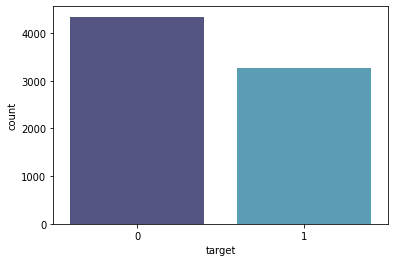

In [64]:
print("target : 0 = Not a Disaster, 1 = Disaster")
print(train["target"].value_counts())
sns.countplot(x="target",data=train,palette='ocean',alpha=0.7)

Keyword

In [65]:
print ('Unique keywords in train: ', train.keyword.nunique())
print ('Unique keywords in test: ', test.keyword.nunique())

Unique keywords in train:  221
Unique keywords in test:  221


In [66]:
set_difference = set(train.keyword.unique()) - set(test.keyword.unique())
set_difference

set()

Hence all keywords in the train and test data are the same.

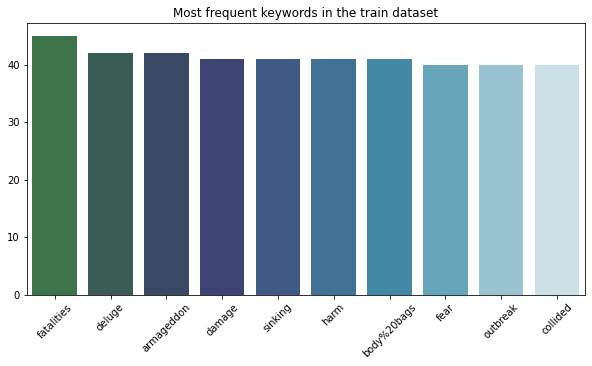

In [67]:
train_key=train.keyword.value_counts()[:10]
plt.figure(figsize=(10,5))
plt.xticks(rotation=45)
plt.title("Most frequent keywords in the train dataset")
sns.barplot(train_key.index,train_key.values,palette="ocean",alpha=0.8)

In [0]:
disaster=train.loc[train["target"]==1]
not_a_disaster=train.loc[train["target"]==0]

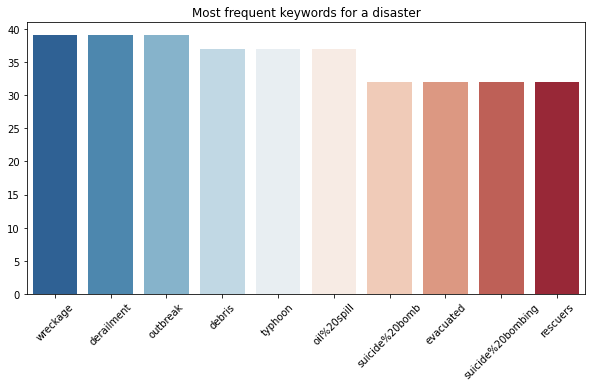

In [69]:
disaster_key=disaster.keyword.value_counts()[:10]
plt.figure(figsize=(10,5))
plt.xticks(rotation=45)
plt.title("Most frequent keywords for a disaster")
sns.barplot(disaster_key.index,disaster_key.values,palette="RdBu_r")

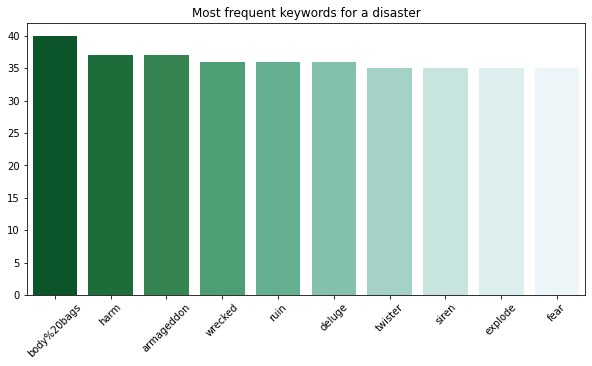

In [70]:
nondisaster_key=not_a_disaster.keyword.value_counts()[:10]
plt.figure(figsize=(10,5))
plt.xticks(rotation=45)
plt.title("Most frequent keywords for a disaster")
sns.barplot(nondisaster_key.index,nondisaster_key.values,palette="BuGn_r")

Location

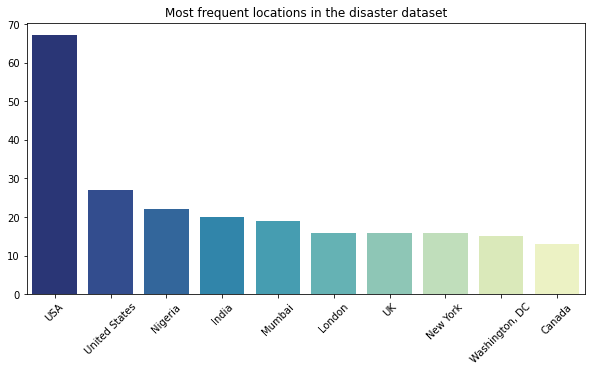

In [71]:
disaster_loc=disaster.location.value_counts()[:10]
plt.figure(figsize=(10,5))
plt.xticks(rotation=45)
plt.title("Most frequent locations in the disaster dataset")
sns.barplot(disaster_loc.index,disaster_loc.values,palette="YlGnBu_r")

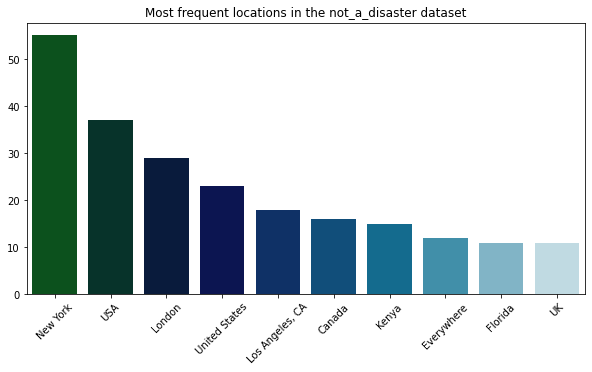

In [72]:
nondisaster_loc=not_a_disaster.location.value_counts()[:10]
plt.figure(figsize=(10,5))
plt.xticks(rotation=45)
plt.title("Most frequent locations in the not_a_disaster dataset")
sns.barplot(nondisaster_loc.index,nondisaster_loc.values,palette="ocean")

# Data Cleaning

Let's fill missing values in train and test data with " " for now.

In [0]:
train = train.fillna('')
test = test.fillna('')

The first round of data cleaning is removing any emojis

In [0]:
def clean1(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

In [0]:
train["text"]=train["text"].apply(lambda x: clean1(x))
test["text"]=test["text"].apply(lambda x: clean1(x))

Second round of cleaning is removing links , hashtags and mentions/usernames.

In [0]:
def clean2(string):
  tweet=string.lower()
  tweet=re.sub(r"https?\S+"," ",tweet)
  tweet=re.sub("#"," ",tweet)
  tweet=re.sub(r"^@\w+"," ",tweet)
  return tweet

In [0]:
train["text"]=train["text"].apply(lambda x: clean2(x))
test["text"]=test["text"].apply(lambda x: clean2(x))

using the TreeBankWordTokenizer

In [0]:
train["text"]=train["text"].apply(lambda x: tokenizer.tokenize(x))
test["text"]=test["text"].apply(lambda x: tokenizer.tokenize(x))

In [0]:
def clean3(string):
  tweet = ' '.join(string)
  tweet=re.sub("'s","is",tweet)
  tweet=re.sub("n't","not",tweet)
  tweet=re.sub("'m","am",tweet)
  return tweet

In [0]:
train["text"]=train["text"].apply(lambda x: clean3(x))
test["text"]=test["text"].apply(lambda x: clean3(x))

Removing further noise in the data

In [0]:
def clean4(string):
  tweet=string
  tweet=re.sub(r"\W+"," ",tweet)
  tweet=re.sub(r"\d+"," ",tweet)
  tweet=re.sub("_"," ",tweet)
  tweet=re.sub(r"\b\w\w\b"," ",tweet)
  tweet=re.sub(r"\b\w\b"," ",tweet)
  return tweet

In [0]:
train["text"]=train["text"].apply(lambda x: clean4(x))
test["text"]=test["text"].apply(lambda x: clean4(x))

Location

In [0]:
loc=set(train["location"])

We will clean all the digits and symbols from the text.
We won't lowercase the string as they are location names and it may also help us to differentiate actual locations from noisy data

In [0]:
def loc_clean1(string):
  location=string
  location=re.sub(r"\d+"," ",location)
  location=re.sub(r"\W+"," ",location)
  return location

In [0]:
train["location"]=train["location"].apply(lambda x: loc_clean1(x))
test["location"]=test["location"].apply(lambda x: loc_clean1(x))

Keywords

In [0]:
key=set(train["keyword"])

we apply the same cleaning as location

In [0]:
train["keyword"]=train["keyword"].apply(lambda x: loc_clean1(x))
test["keyword"]=test["keyword"].apply(lambda x: loc_clean1(x))

In [0]:
train["data"] =   train['text'] #train['keyword'] +' '+train['location'] +' '+
test["data"] =  test['text'] #test['keyword'] +' '+ test['location'] +' '+

We get better accuracy for this model witholding the location and keyword attribute.

#Stemming

In [89]:
"""train["data"]=[ps.stem(word) for word in train.data if 
                     word not in set(stopwords.words('english'))]
test["data"]=[ps.stem(word) for word in test.data if 
                     word not in set(stopwords.words('english'))] """

'train["data"]=[ps.stem(word) for word in train.data if \n                     word not in set(stopwords.words(\'english\'))]\ntest["data"]=[ps.stem(word) for word in test.data if \n                     word not in set(stopwords.words(\'english\'))] '

#Lemmatizing

In [0]:
train["data"]=[lemmatizer.lemmatize(word) for word in train.data if 
                     word not in set(stopwords.words('english'))]
test["data"]=[lemmatizer.lemmatize(word) for word in test.data if 
                     word not in set(stopwords.words('english'))]

#Vectorizing

**CountVectorizer**

In [0]:
cv = CountVectorizer(ngram_range = (1,3))
text_counts_train= cv.fit_transform(train["data"])
text_counts_test= cv.transform(test["data"])

In [0]:
X=text_counts_train
y=train[["target"]]
test=text_counts_test

**Tf**-**idf** **Vectorizer**

In [93]:
"""tfidf_v=TfidfVectorizer(ngram_range=(1,3))
text_tf_train=tfidf_v.fit_transform(train["data_train"])
text_tf_test=tfidf_v.transform(test["data_train"])"""

'tfidf_v=TfidfVectorizer(ngram_range=(1,3))\ntext_tf_train=tfidf_v.fit_transform(train["data_train"])\ntext_tf_test=tfidf_v.transform(test["data_train"])'

In [94]:
"""X_train=text_tf_train
y_train=train[["target"]]
X_test=text_tf_test """

'X_train=text_tf_train\ny_train=train[["target"]]\nX_test=text_tf_test '

#Modelling

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=9)

Logistic Regression

In [96]:
"""logreg = LogisticRegression()
logreg.fit(X_train,y_train)
y_pred = logreg.predict(X_test)"""

'logreg = LogisticRegression()\nlogreg.fit(X_train,y_train)\ny_pred = logreg.predict(X_test)'

In [0]:
#pd.DataFrame(confusion_matrix(y_test,y_pred))

In [0]:
#accuracy_score(y_test, y_pred)

In [99]:
"""logreg.fit(X,y)
y_pred = logreg.predict(test)"""

'logreg.fit(X,y)\ny_pred = logreg.predict(test)'

Naive Bayes

In [0]:
clf = MultinomialNB().fit(X,y)
y_pred= clf.predict(test)

# Exporting csv

In [0]:
y_pred=pd.DataFrame(y_pred)
y_pred.rename(columns = {0:'target'}, inplace = True)
id=test_copy[["id"]]
y_pred= pd.concat([id, y_pred], axis=1)
y_pred=pd.DataFrame(y_pred)

In [0]:
export_csv=y_pred.to_csv('new7.csv', index=None,header=True)